## Анализ образцов рака поджелудочной железы

Данные находятся по ссылке: https://xenabrowser.net/datapages/?cohort=PACA-AU&removeHub=https%3A%2F%2Fxena.treehouse.gi.ucsc.edu%3A443  

*Поджелудочная железа* - небольшой орган, находящийся в брюшной полости человека и выполняющий как эндокринную функцию (синтез инсулина и др. гормонов), так и экзокринную функцию (выделение пищеварительного секрета с ферментами через протоки в кишечник). *Рак поджелудочной железы* - это злокачественная опухоль, поражающая ткани поджелудочной железы.  

<img src="pancreas.jpg" alt="drawing" width='500'/>

Рак поджелудочной железы занимает седьмое место по смертности среди остальных злокачественных опухолей ([Rawla et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6396775/)). Одна из причин высокой смертности от рака поджелудочной - диагноз чаще всего ставится на поздних этапах развития заболевания, поскольку отсутствует выраженная специфическая симптоматика болезни. Пятилетняя выживаемость после постановки диагноза крайне низкая и находится на уровне 10%  ([cancer.gov](https://seer.cancer.gov/statfacts/html/pancreas.html)).  

Для терапии рака поджелудочной железы используют стандартные методы. Хирургическое удаление пораженных тканей дает более благоприятный прогноз, однако такая операция возможна не во всех случаях и только до метастазирования опухоли. Также используется химиотерапия, лучевая терапия и таргетная терапия (ингибиторы тирозинкиназ) ([canver.gov](https://www.cancer.gov/types/pancreatic/patient/pancreatic-treatment-pdq#section/all)).

Рак поджелудочной железы - это полигенное заболевание, аллели многих генов могут вносить как небольшой, так и значительный вклад в развитие заболевания. Высоким риском обладают гены, связанные с другими заболеваниями поджелудочной железы и ЖКТ: например, ген STK11, мутации в котором вызывают синдром Пейтца-Егертса (полипоз ЖКТ); ген PRSS1, мутации в котором вызывают наследственный панкреатит. Кроме того, высокий риск развития рака поджелудочной железы ассоциируется нарушениями в некоторых метаболических путях: например, мутации генов HNF1A, HNF4G, HNF1B и PDX1, задействованных в эмбриональном развитии поджелудочной железы и в поддержании ее жизнедеятельности; мутации в генах HNF1A, PDX1, и HNF1B, ассоциированных с развитием MODY-диабета ([Amundadottir, 2016](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4753160/)).  

Риск возникновения рака поджелудочной увеличивается с возрастом. Кроме возраста, к факторам риска относится курение, лишний вес, диабет и панкреатит в анамнезе и т.д. ([cancer.gov](https://www.cancer.gov/types/pancreatic/patient/pancreatic-treatment-pdq#section/all)). 


Нами были проанализированны данные по экспрессии генов 96 образцов опухолевой ткани. Каждый образец относился к одному из четырех подтипов опухоли, выявленных в исследовании [Bailey et al., 2016](https://www.nature.com/articles/nature16965): к типу "squamous", "pancreatic progenitor", "immunogenic" и "ADEX". Значения экспрессии были предварительно нормализованы авторами статьи (logCPM).

In [1]:
# использованные библиотеки
import pandas as pd
import biomart
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from lifelines import KaplanMeierFitter

### Импорт данных и составление таблицы экспрессии

In [2]:
# данные по экспрессии
df = pd.read_csv("nature16965-s2_normalised_exp.txt", sep = '\t')

# данные по соответствию названий генов и их id
id_to_gene = pd.read_csv('ensembleGene_hg19_nature16965-s2_normalised_exp', sep = '\t')

# данные по подтипам
phenotypes = pd.read_csv('nature16965-s2_NMF_class_assignment.txt', sep = '\t')

# дополнительная информация об образцах
supp = pd.read_csv("suppl.csv", sep = ',')

In [3]:
# индексирование таблицы экспресии, добавление информации о подтипах и генах

# гены
df.rename(columns={'Unnamed: 0':'id'}, inplace=True )
df['gene'] = df.iloc[:,0].map(id_to_gene.set_index('#id')['gene'])
df.set_index(["gene", "id"], inplace = True)

# подтипы
arr = df.columns.map(phenotypes.set_index('icgc_id')['expression subtype'])
idx = pd.MultiIndex.from_tuples((zip(arr, 
        df.columns)), names=('phenotype', 'obs'))
df.columns = idx
df.sort_index(axis=1, level=0, inplace=True)

In [4]:
# готовая таблица экспрессии
df.head()

phenotype                     ADEX                                          \
obs                      ICGC_0006 ICGC_0026 ICGC_0033 ICGC_0048 ICGC_0052   
gene     id                                                                  
TSPAN6   ENSG00000000003  4.935214  4.817511  5.409023  5.044888  5.318540   
DPM1     ENSG00000000419  4.034635  4.443624  4.051100  4.708546  4.568621   
SCYL3    ENSG00000000457  3.925488  3.676183  3.612081  4.973575  3.650884   
C1orf112 ENSG00000000460  2.483618  2.686024  2.956476  3.411012  2.551562   
FGR      ENSG00000000938  2.484806  2.527272  1.636456  2.285248  0.804320   

phenotype                                                                   \
obs                      ICGC_0075 ICGC_0103 ICGC_0146 ICGC_0201 ICGC_0205   
gene     id                                                                  
TSPAN6   ENSG00000000003  4.272855  4.134638  4.328057  5.816421  4.587716   
DPM1     ENSG00000000419  3.472525  4.162068  4.276050  4.234437  4.390071   
SCYL3    ENSG00000000457  4.197544  4.286665  4.165935  5.187106  4.126033   
C1orf112 ENSG00000000460  2.842177  2.483838  2.668201  3.846406  2.500377   
FGR      ENSG00000000938  2.353310  1.312036  2.062029  1.772253  2.201072   

phenotype                 ...  Squamous                                \
obs                       ... ICGC_0313 ICGC_0315 ICGC_0321 ICGC_0326   
gene     id               ...                                           
TSPAN6   ENSG00000000003  ...  4.683364  4.461632  5.119372  4.923180   
DPM1     ENSG00000000419  ...  4.454059  4.198926  4.877056  4.526634   
SCYL3    ENSG00000000457  ...  3.326885  3.523828  3.513792  3.232391   
C1orf112 ENSG00000000460  ...  3.188970  2.544170  2.755799  3.110667   
FGR      ENSG00000000938  ...  3.436166  1.768460  0.811249  2.136982   

phenotype                                                                   \
obs                      ICGC_0392 ICGC_0393 ICGC_0521 ICGC_0522 ICGC_0535   
gene     id                                                                  
TSPAN6   ENSG00000000003  5.047768  4.646256  5.382327  4.308381  3.332555   
DPM1     ENSG00000000419  4.573917  4.312425  4.001015  3.272052  4.601348   
SCYL3    ENSG00000000457  3.153032  4.235636  4.569100  4.477992  3.672093   
C1orf112 ENSG00000000460  2.414302  3.155496  3.048836  3.573936  2.918784   
FGR      ENSG00000000938  2.569979  2.595526  1.311957  3.346237  3.614184   

phenotype                           
obs                      ICGC_0543  
gene     id                         
TSPAN6   ENSG00000000003  5.140055  
DPM1     ENSG00000000419  5.284458  
SCYL3    ENSG00000000457  3.101123  
C1orf112 ENSG00000000460  3.477693  
FGR      ENSG00000000938  2.123467  

[5 rows x 96 columns]

К каждому из подтипов рака поджелудочной относится от 16 до 30 образцов, конкретные числа находятся в таблице ниже. Подтипы выделялись исследователями в зависимости от характеристик метаболических путей, обогащенных в том или ином классе данных.  

В подтипе "Squamous" обогащены пути, задействованные в воспалительных процессах, TGF-β (ростовой фактор) - сигналлинге, реакции на гипоксию и т.п. Эти же пути часто обогащены в сквамозном типе опухолей легких, мочевого пузыря и т.п., поэтому данный подтип рака поджелудочный также назвали сквамозным.  

Подтип "Pancreatic progenitor" определяется высокой экспрессией транскрипционных факторов PDX1, MNX1, HNF4G, HNF4A, HNF1B, HNF1A, FOXA2, FOXA3 и HES1 - они играют роль в определении ранней судьбы клеток эндодермы поджелудочной железы, а также связаны с развитием MODY-диабета.   

В подтипе "ADEX" наблюдается высокая экспрессия транскрипционных факторов NR5A2, MIST1 и RBPJL, работающих на поздних этапах развития поджелудочной железы.

Подтип "Immunogenic" во многом похож на подтип "Pancreatic progenitor"; также он ассоциируется с повышенной активностью клеток иммунной системы.

In [5]:
# число образцов, относящихся к каждому из подтипов
df.T.groupby(level=0).size()

phenotype
ADEX                     16
Immunogenic              25
Pancreatic Progenitor    30
Squamous                 25
dtype: int64

### Оценка качества данных, поиск выбросов и batch-эффекта  
Перед анализом данных экспрессии необходимо понять структуру данных, избавиться от некоторых генов, не несущих значимой информации, оценить возможные источники batch-эффекта.

Сначала мы проведем анализ главных компонент на сырых данных, чтобы понять, как кластеризуются образцы и есть ли видимые проблемы. Анализ будет повторен и после чистки данных.

In [6]:
# стандартизируем данные перед анализом главных компонент
x = StandardScaler().fit_transform(df.T.values)
scaled_df = pd.DataFrame(x, index=df.T.index, columns=df.T.columns)

# уменьшение многомерности до двух компонент
pca_df= PCA(n_components=2)
principal_df = pd.DataFrame(data = pca_df.fit_transform(scaled_df),
                            columns = ['principal component 1', 'principal component 2'],
                            index=df.T.index)
# доля дисперсии, объясненной двумя компонентами
print('Объясненная дисперсия: {}'.format(pca_df.explained_variance_ratio_))

Объясненная дисперсия: [0.11783207 0.08079479]


Процент обясненной дисперсии при уменьшении размерности достаточно мал (в сумме по двум компонентам около 19%, однако для данных с микрочипов и при таком большом количестве генов это нормально. 

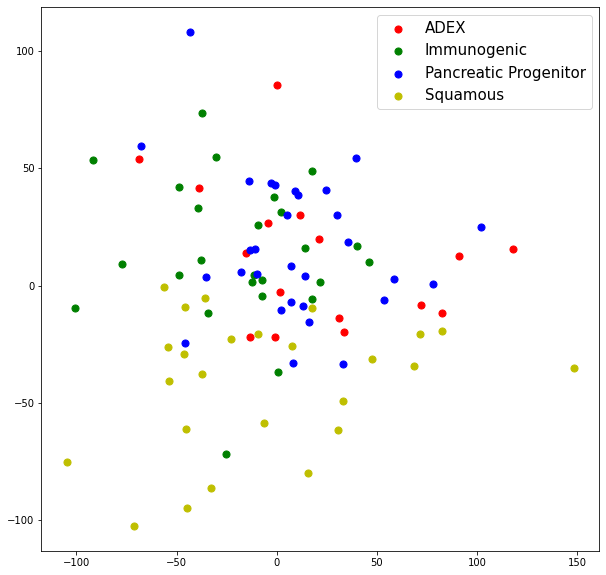

In [7]:
# график
plt.figure(figsize=(10,10))

targets = df.T.index.levels[0]
colors = ['r', 'g', 'b', 'y']
for target, color in zip(targets,colors):
    plt.scatter(principal_df.loc[target, 'principal component 1'], 
                principal_df.loc[target, 'principal component 2'],
                c = color, s = 50)
plt.legend(targets,prop={'size': 15});

На графике не заметны четкие группировки образцов, однако уже видно, что образцы сквамозного типа достаточно хорошо отделяются от остальных.

Попробуем кластеризовать образцы и посмотрим, кластеризуются ли подтипы вместе.

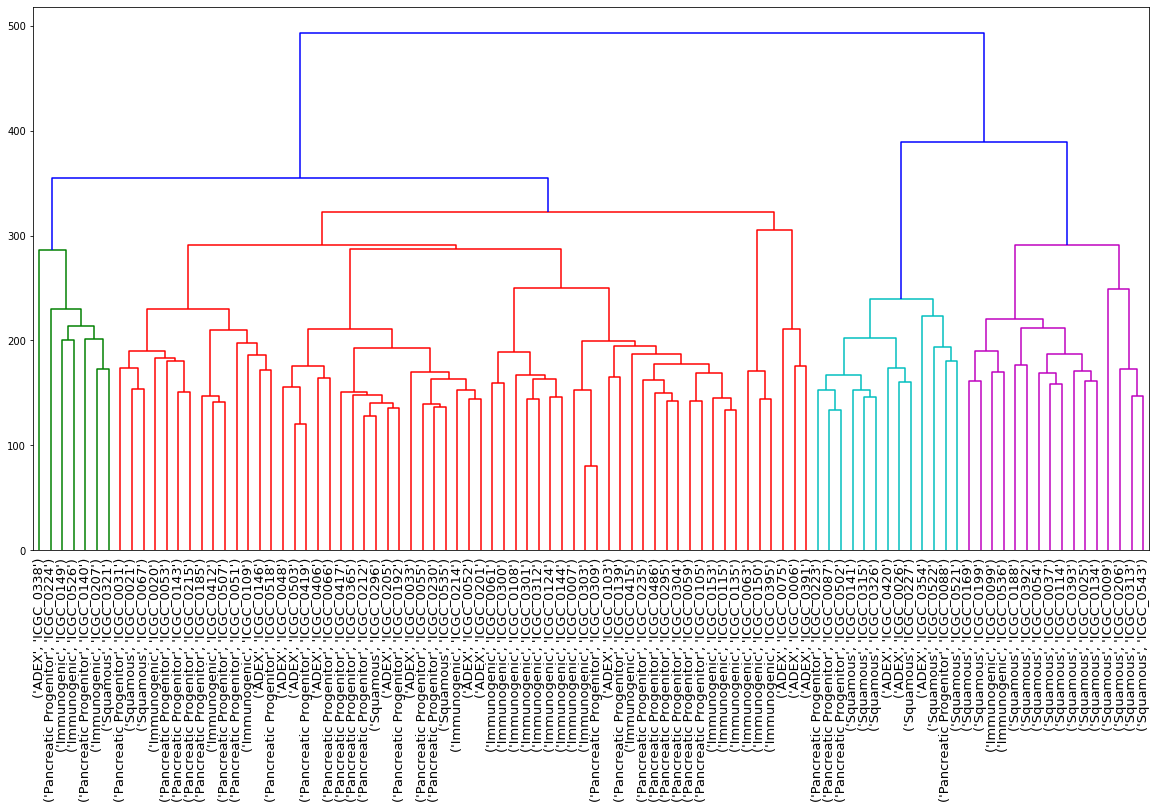

In [8]:
# кластерный анализ
linked = linkage(df.T, 'ward')
plt.figure(figsize=(20, 10))
dendrogram(linked, labels=df.T.index, leaf_font_size=13)
plt.show()

Пока что данные не очень хорошо кластеризуются по подтипам рака.

Исследуем распределение значений экспрессии по группам, а также внутри каждой группы.

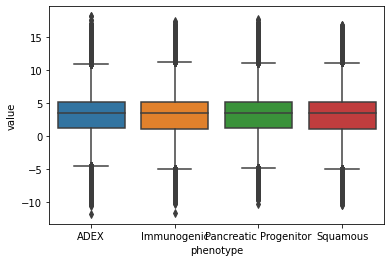

In [9]:
sns.boxplot(x="phenotype", y="value", data = pd.melt(df));

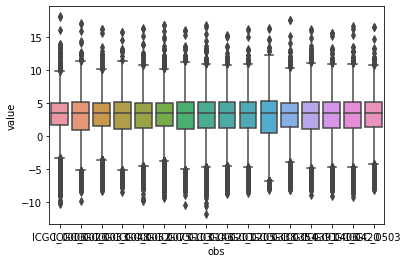

In [10]:
sns.boxplot(x="obs", y="value", data = pd.melt(df)[pd.melt(df)['phenotype']=='ADEX']);

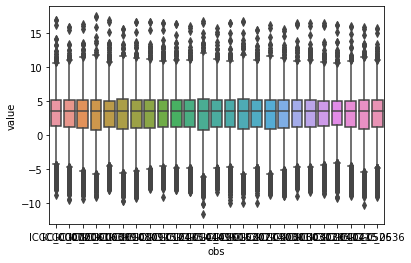

In [11]:
sns.boxplot(x="obs", y="value", data = pd.melt(df)[pd.melt(df)['phenotype']=='Immunogenic']);

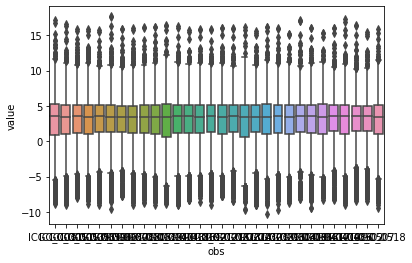

In [12]:
sns.boxplot(x="obs", y="value", data = pd.melt(df)[pd.melt(df)['phenotype']=='Pancreatic Progenitor']);

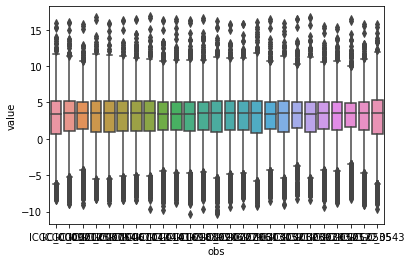

In [13]:
sns.boxplot(x="obs", y="value", data = pd.melt(df)[pd.melt(df)['phenotype']=='Squamous']);

Значения экспрессии в зависимости от подтипа распределены примерно одинаково, как и ожидалось при таком большом числе исследуемых генов. Значения экспрессии внутри каждого подтипа также распределены примерно одинаково, нет видимых выбросов, поэтому все образцы будут сохранены в исследовании. 

Поскольку в данном датасэте нет очевидного фактора, который вносил бы батч-эффект (например, образцы точно из разных лабораторий и т.п., а также нет заметной группировки образцов по каким-то признакам, отличным от подтипа рака, и не наблюдается выбросов, коррекция батч-эффекта в данном случае проведена не будет (к тому же, большинство стандартных библиотек для коррекции батч-эффекта написаны на R).  

Однако, из датасэта будут удалены транскрипты неопределенной природы, дуплицированные гены и гены с очень низкой дисперсией (которые, очевидно, не являются значимыми для определения подтипа опухоли). В итоге в исследование включены около 10тыс генов.

In [14]:
# удаляем строки, содержащие NA 
na = df.reset_index().dropna()
na.set_index(["gene", "id"], inplace = True)

# оставляем по одной копии из повторяющихся генов
idx = np.unique(na.reset_index('id').index, return_index=True)[1]
na = na.iloc[idx]

# делаем для генов отсечку по дисперсии, оставляя около 7 тыс наиболее значимых генов
selector = VarianceThreshold(0.5)
pd.DataFrame(selector.fit_transform(na.T))
na_var = na[selector.get_support()==True]

# размерности изначального датасэта и нового
print(df.shape)
print(na.shape)
print(na_var.shape)

(18278, 96)
(18077, 96)
(7643, 96)


In [15]:
na_var.head()

phenotype                     ADEX                                          \
obs                      ICGC_0006 ICGC_0026 ICGC_0033 ICGC_0048 ICGC_0052   
gene     id                                                                  
A1BG-AS1 ENSG00000268895  1.305810 -0.286756  0.850791  0.146911 -0.322223   
A1CF     ENSG00000148584  1.094713  2.660673  2.856381  2.323466 -0.276465   
A2M      ENSG00000175899  8.905039  8.573659  9.560324  9.277623  8.623443   
A2M-AS1  ENSG00000245105  1.499668 -1.419210  1.047311 -1.060882  0.555015   
A2ML1    ENSG00000166535 -1.974951  5.934133  0.003488 -3.061682 -2.779242   

phenotype                                                                   \
obs                      ICGC_0075 ICGC_0103 ICGC_0146 ICGC_0201 ICGC_0205   
gene     id                                                                  
A1BG-AS1 ENSG00000268895  0.306838 -1.583268 -0.630912  0.747047  0.603692   
A1CF     ENSG00000148584  4.246552  3.099565 -0.270564  1.108264  1.907056   
A2M      ENSG00000175899  9.468949  8.035851  9.602285  9.110293  8.607084   
A2M-AS1  ENSG00000245105  0.848560 -0.776354 -0.089076 -0.503065 -0.656305   
A2ML1    ENSG00000166535  0.218625 -2.811313  8.612184 -3.406480  1.200051   

phenotype                 ...  Squamous                                \
obs                       ... ICGC_0313 ICGC_0315 ICGC_0321 ICGC_0326   
gene     id               ...                                           
A1BG-AS1 ENSG00000268895  ...  0.476180  0.233213 -1.667660  1.118794   
A1CF     ENSG00000148584  ... -3.808196  0.603577 -2.613752  0.923825   
A2M      ENSG00000175899  ...  8.100587  8.056768  8.181085  8.636581   
A2M-AS1  ENSG00000245105  ... -0.457326 -0.064119 -0.565148 -0.738324   
A2ML1    ENSG00000166535  ...  6.797634  5.891339  2.087202  2.896174   

phenotype                                                                   \
obs                      ICGC_0392 ICGC_0393 ICGC_0521 ICGC_0522 ICGC_0535   
gene     id                                                                  
A1BG-AS1 ENSG00000268895 -0.630163  0.430823 -1.365825  0.636058  0.533977   
A1CF     ENSG00000148584 -4.933321  0.487837 -3.727138  2.526507 -0.751363   
A2M      ENSG00000175899  8.359945  7.260048  7.354976  8.620803  9.461214   
A2M-AS1  ENSG00000245105 -1.400101 -0.425611  0.666209  0.395528  0.360843   
A2ML1    ENSG00000166535  3.451833  6.161134  4.298288 -0.725385  1.334690   

phenotype                           
obs                      ICGC_0543  
gene     id                         
A1BG-AS1 ENSG00000268895  0.106548  
A1CF     ENSG00000148584 -4.933321  
A2M      ENSG00000175899  8.356385  
A2M-AS1  ENSG00000245105 -1.166072  
A2ML1    ENSG00000166535  7.888032  

[5 rows x 96 columns]

Проведем анализ главных компонент и кластерный анализ, чтобы понять, если ли различия с изначальным набором данных.

In [16]:
# стандартизируем данные перед анализом главных компонент
x = StandardScaler().fit_transform(na_var.T.values)
scaled_na_var = pd.DataFrame(x, index=na_var.T.index, columns=na_var.T.columns)

# уменьшение многомерности до двух компонент
pca_na_var= PCA(n_components=2)
principal_na_var = pd.DataFrame(data = pca_na_var.fit_transform(scaled_na_var),
                            columns = ['principal component 1', 'principal component 2'],
                            index=na_var.T.index)
# доля дисперсии, объясненной двумя компонентами
print('Объясненная дисперсия: {}'.format(pca_na_var.explained_variance_ratio_))

Объясненная дисперсия: [0.11146437 0.09956778]


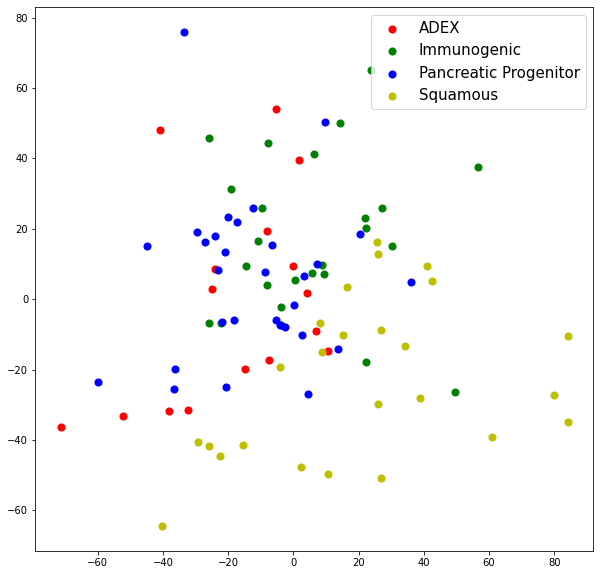

In [17]:
# график
plt.figure(figsize=(10,10))

targets = na_var.T.index.levels[0]
colors = ['r', 'g', 'b', 'y']
for target, color in zip(targets,colors):
    plt.scatter(principal_na_var.loc[target, 'principal component 1'], 
                principal_na_var.loc[target, 'principal component 2'],
                c = color, s = 50)
plt.legend(targets,prop={'size': 15});

Процент объясненной дисперсии незначительно увеличился. На графике образцы более заметно группируются по подтипам рака.

Попробуем кластеризовать новый датасэт.

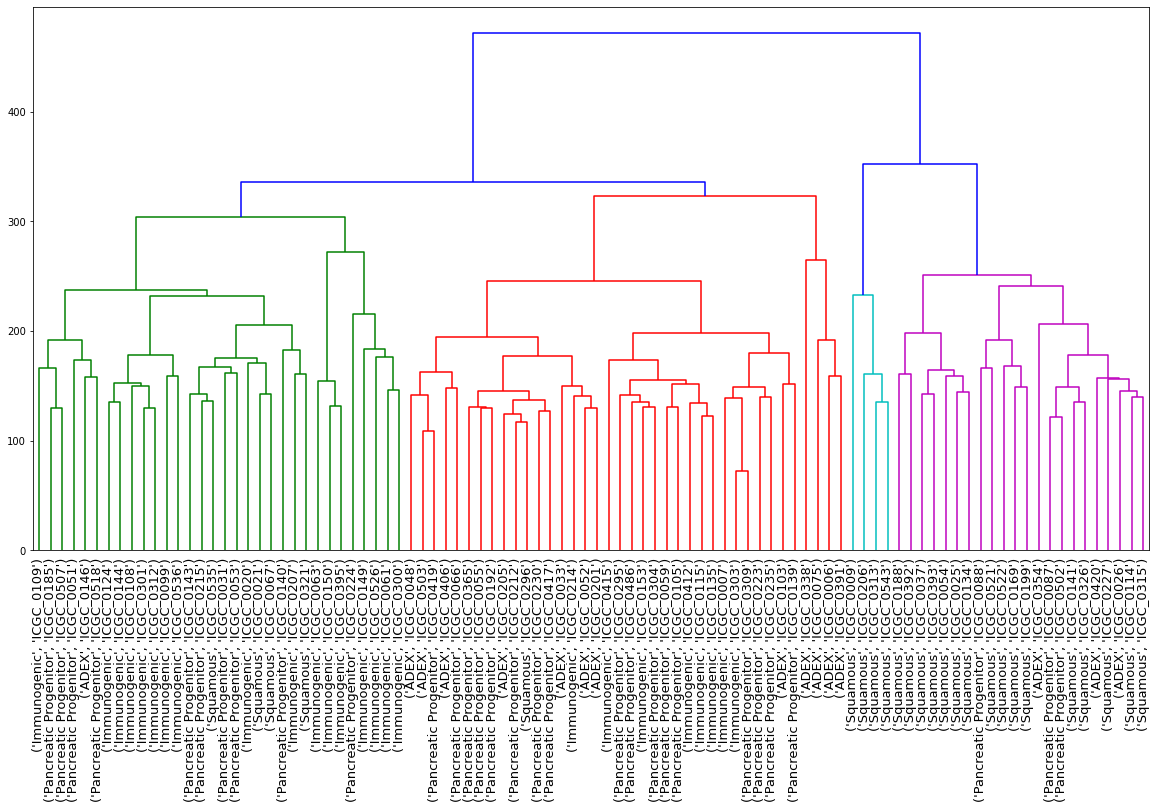

In [18]:
# кластерный анализ
linked = linkage(na_var.T, 'ward')
plt.figure(figsize=(20, 10))
dendrogram(linked, labels=na_var.T.index, leaf_font_size=13)
plt.show()

Практически все образцы сквамозного типа попали в одну группу, однако все еще не заметно четкого разделения кластеров, которое наблюдалось у авторов статьи. Это может быть связано с тем, что мы используюм другой механизм кластеризации и берем в анализ большее число генов (7 тыс против 2 тыс у авторов).  

На тепловой карте датасэта так же не заметны отдельные подтипы. 

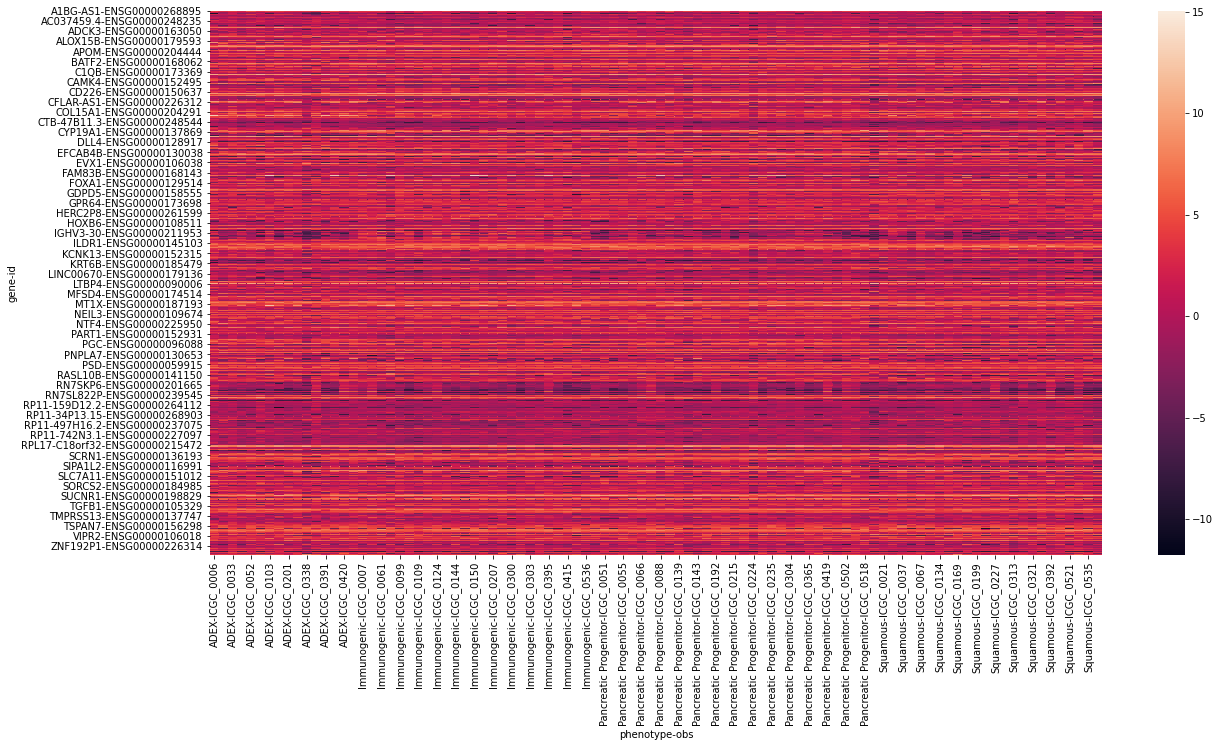

In [19]:
plt.figure(figsize=(20, 10))
sns.heatmap(na_var);

In [20]:
# запись данных в файл
df.to_csv('df.csv', sep='\t')
na_var.to_csv('na_var.csv', sep='\t')

### Анализ дифференциальной экспрессии генов  
Поиск значимых для того или иного подтипа генов был осуществлен с помощью программы ["Phantasus"](https://ctlab.itmo.ru/phantasus/) и встроенного в него R-пакета [limma](http://bioconductor.org/packages/release/bioc/html/limma.html).   

Сравнивались образцы каждого типа против остальных типов рака поджелудочной. Значимые гены выбирались с отсечкой максимум 0.01 по p-value adjusted. Топ-50 значимых для данного подтипа генов далее анализировались с помощью [Enrichr](https://amp.pharm.mssm.edu/Enrichr/) методом GSEA. GSEA - это анализ для поиска статистически значимых ассоциаций между определенными генами интереса и фенотипом, т.е. проявлением каких-либо признаков, метаболических путей и т.п. С помощью этого метода можно извлечь из профиля экспрессии информацию о реальных биологических механизмах.

Приведены картинки только для некоторых вариантов сравнений подтипов.

#### ADEX vs. rest
<img src="ADEX.png" alt="drawing"/>

Топ-50 генов (выделены некоторые гены, встречающиеся и в статье): GAMT KIRREL2 APLP1 GP2 ERP27 CTRL SERPINI2 KCNK3 CTRC PNLIPRP2 REG3A PNLIPRP1 PRSS1 **PRBJL** REG3G KLK1 FGL1 RP11-331F4.4 SLC1A2 AQP8 SV2B PRSS3 CELA2A CPA2 PDIA2 CELA2B CPA1 CTRB2 CEL PRSS3P1 SLC16A12 SLC30A2 PRSS3P2 NPHS1 CLPS SYCN CTRB1 PNLIP REG1A CELA3A CELA3B BRSK2 AMY2A AMY2B CPB1 PLA2G1B REG1B CUZD1 REG1P SLC38A3




По данным Enrichr в базе DisGeNET нашлось много значимых ассоциаций данных генов с болезнями, например, с панкреатитом, что подтверждает валидность нашего анализа.

<img src="ADEX_1.png" alt="drawing"/>

Также данные гены были ассоциированы с метаболическими путями, отвечающими, например, за жизнедеятельность поджелудочной железы. Это согласуется с данными оригинальной статьи.

<img src="ADEX_2.png" alt="drawing"/>

#### Squamous vs. Pancreatic Progenitor

Гены, которые в сквамозном типе экспрессируются сильнее, чем в pancreatic progenitor
<img src="PAN-down.png" alt="drawing"/>

Метаболические пути, в которые вовлечены гены, экспрессирующиеся сильнее в сквамозном типе, включают в себя путь, играющий роль в метастазировании, что также согласуется с результатами статьи.

<img src="Sq-up.png" alt="drawing"/>


#### Immunogenic vs. Pancreatic progenitor

Гены, которые в иммуногенном типе экспрессируются сильнее, чем в pancreatic progenitor
<img src="Im-Pan.png" alt="drawing"/>

Гены, которые экспрессируются в типе immunogenic сильнее, чем в pancreatic progenitor - это гены, вовлеченные в иммунный ответ, что согласуется с данными статьи

<img src="Imm-up.png" alt="drawing"/>

### Поиск закономерностей между типом рака и информацией о пациентах
Нам интересно, отличаются ли различные подтипы рака поджелудочной по некоторым параметрам пациентов. Информация о пациентах находится в датасэте supp, информация о подтипах - в датасэте phenotypes.

Для начала готовим общий датасэт с информацией о подтипах рака и о параметрах образцов.

In [21]:
# исключаем ненужную информацию
supp = supp.drop(['EXOME', 'WGS', 'RNASeq', 'HT-12 Expression array', '450K Methylation arrays', 'SV analysis'], 
                 axis=1)
# индексируем
supp.set_index('icgc_id', inplace=True, drop=True)
# удаляем ненужные образцы
supp.drop([col for col in supp.index if col not in na_var.T.index.levels[1].values], inplace=True)

# индексируем датасэт с подтипами
phenotypes.set_index('icgc_id', inplace=True, drop=True)
# сливаем два датасэта
phenotypes = pd.concat([phenotypes, supp],axis=1, join='inner')
# устанавливаем правильные типы данных
phenotypes[["qpure_score", "Age at Diagnosis in Years", 'Length of Follow Up (months)']] \
    =phenotypes[["qpure_score", "Age at Diagnosis in Years", 'Length of Follow Up (months)']].apply(pd.to_numeric)
phenotypes.head()

,expression subtype,Sample type,qpure_score,qpure >40%,KRAS BY WTS or WES,KRAS by Deep Amplicon,SNP,Ethnicity,Gender,Age at Diagnosis in Years,Country,Smoker,Tumour Grade,HistoSubtype,Tumour Location,AJCC Pathology Stage,Status,Length of Follow Up (months)
icgc_id,,,,,,,,,,,,,,,,,,
ICGC_0543,Squamous,Primary tumour,64,YES,Y,Y,YES,White/Caucasian,Male,67,Australia,Stopped Smoking,Not documented,PDA - Adenosquamous carcinoma,Tail,IIA,Deceased - Of Disease,5.2
ICGC_0522,Squamous,Primary tumour,58,YES,Y,Y,YES,White/Caucasian,Female,56,United Kingdom,Not documented,3 - Poorly differentiated,Pancreatic Ductal Adenocarcinoma,Head,IIB,Deceased - Of Disease,15.0
ICGC_0521,Squamous,Primary tumour,78,YES,Y,Y,YES,White/Caucasian,Female,51,United Kingdom,Not documented,2 - Moderately differentiated,Pancreatic Ductal Adenocarcinoma,Tail,IV,Deceased - Of Disease,14.1
ICGC_0535,Squamous,Primary tumour,54,YES,Y,Y,YES,White/Caucasian,Female,40,Australia,Not documented,3 - Poorly differentiated,Pancreatic Ductal Adenocarcinoma,Head,IIB,Alive - With Disease,9.4
ICGC_0313,Squamous,Primary tumour,50,YES,Y,Y,YES,White/Caucasian,Female,77,Australia,Stopped Smoking,3 - Poorly differentiated,PDA - Adenosquamous carcinoma,Head,IV,Alive - Without Disease,17.0


Сравнение процента содержания раковых клеток в образце биопсии в разных подтипах рака. Медианное значение примерно одинаковое для каждого подтипа, в подтипе ADEX содержание статистически выше, чем в остальных.

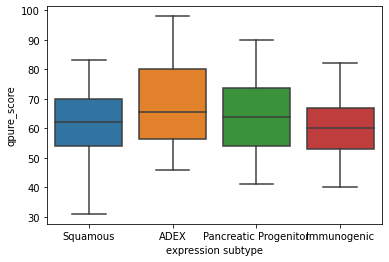

In [22]:
# график
sns.boxplot(x='expression subtype', y = 'qpure_score', data = phenotypes);

In [23]:
# базовые статистики
phenotypes.groupby('expression subtype')['qpure_score'].describe()

,count,mean,std,min,25%,50%,75%,max
expression subtype,,,,,,,,
ADEX,16.0,66.937500,15.048671,46.0,56.5,65.5,80.25,98.0
Immunogenic,25.0,60.800000,11.930353,40.0,53.0,60.0,67.00,82.0
Pancreatic Progenitor,30.0,64.933333,14.185795,41.0,54.0,64.0,73.75,90.0
Squamous,25.0,61.480000,12.014297,31.0,54.0,62.0,70.00,83.0


Какие этносы наиболее подвержены какому-либо подтипу рака. Значения приблизительно одинаковые для каждого подтипа, учитывая небольшую выборку.

In [24]:
phenotypes.groupby(['expression subtype','Ethnicity'])['Ethnicity'].count()

expression subtype     Ethnicity                     
ADEX                   White/Caucasian                   16
Immunogenic            Asian                              2
                       Asian, White/Caucasian             1
                       Not documented                     1
                       White/Caucasian                   21
Pancreatic Progenitor  Asian                              4
                       Black/African                      1
                       Black/African, White/Caucasian     1
                       White/Caucasian                   24
Squamous               Asian                              2
                       Not documented                     1
                       White/Caucasian                   22
Name: Ethnicity, dtype: int64

Различия в половой принадлежности образцов каждого подтипа минимальны.

In [25]:
phenotypes.groupby(['expression subtype','Gender'])['Gender'].count()

expression subtype     Gender
ADEX                   Female     8
                       Male       8
Immunogenic            Female    13
                       Male      12
Pancreatic Progenitor  Female    14
                       Male      16
Squamous               Female    12
                       Male      13
Name: Gender, dtype: int64

Средний возраст постановки диагноза - около 67 лет для каждого подтипа. Наибольший разброс по возрасту наблюдается в подтипе Squamous.

In [26]:
phenotypes.groupby('expression subtype')['Age at Diagnosis in Years'].describe()

,count,mean,std,min,25%,50%,75%,max
expression subtype,,,,,,,,
ADEX,16.0,64.062500,11.357633,46.0,51.75,67.0,74.00,78.0
Immunogenic,25.0,68.240000,9.417537,54.0,60.00,70.0,77.00,83.0
Pancreatic Progenitor,30.0,66.966667,10.135235,37.0,61.00,67.5,73.75,88.0
Squamous,25.0,65.880000,13.944294,34.0,58.00,67.0,77.00,90.0


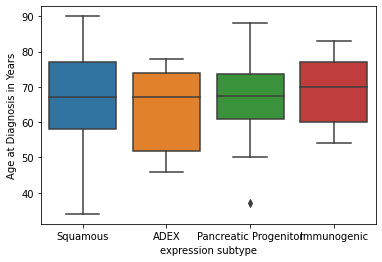

In [27]:
sns.boxplot(x='expression subtype', y = 'Age at Diagnosis in Years', data = phenotypes)

Сравнение подтипов по статусу мутирования гена KRAS. В сквамозном подтипе ген KRAS всегда в мутированном состоянии. Для остальных подтипов соотношение между мутированными и дикими аллелями похожее, мутированных аллелей большинство.

In [28]:
phenotypes.groupby(['expression subtype','KRAS BY WTS or WES'])['KRAS BY WTS or WES'].count()

expression subtype     KRAS BY WTS or WES
ADEX                   N                      4
                       Y                     12
Immunogenic            N                      4
                       Y                     21
Pancreatic Progenitor  N                      3
                       Y                     27
Squamous               Y                     25
Name: KRAS BY WTS or WES, dtype: int64

Грубое сравнение в экспрессии с мутацией KRAS и без нее показывает, что в целом различия минимальны.

In [29]:
no = na_var.T.reset_index('phenotype').drop(phenotypes.index[phenotypes['KRAS BY WTS or WES']=='Y'])
no.groupby('phenotype').mean().T.describe()

/home/gospozha/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


phenotype,ADEX,Immunogenic,Pancreatic Progenitor
count,7643.000000,7643.000000,7643.000000
mean,1.198640,1.342427,1.411702
std,2.874082,2.817248,2.897073
min,-7.696318,-7.263823,-7.953890
25%,-0.759376,-0.668365,-0.573042
50%,0.911404,0.995142,1.080870
75%,3.181102,3.305945,3.334335
max,12.289918,11.666774,12.832425


In [30]:
yes = na_var.T.reset_index('phenotype').drop(phenotypes.index[phenotypes['KRAS BY WTS or WES']=='N'])
yes.groupby('phenotype').mean().T.describe()

/home/gospozha/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


phenotype,ADEX,Immunogenic,Pancreatic Progenitor,Squamous
count,7643.000000,7643.000000,7643.000000,7643.000000
mean,1.532033,1.374615,1.424336,1.297075
std,2.636750,2.824718,2.715258,2.752224
min,-6.731130,-6.504908,-6.269219,-6.624395
25%,-0.435600,-0.776935,-0.622637,-0.695988
50%,1.191716,1.003738,1.014188,0.911553
75%,3.313280,3.348584,3.250032,3.144129
max,12.193488,11.832029,12.113305,12.916482


Различия в выживаемости разных типов рака поджелудочной. В каждом подтипе число смертельных исходов сильно превышает число выздоровевших. Самым опасным подтипом оказывается сквамозный тип - средний период, когда была зарегестрирована смерть пациента, составляет 10 месяцев - меньше, чем для любого другого подтипа. Для образцов иммуногенного подтипа сохраняется достаточно равномерное соотношение выживших и погибших, при этом все выжившие находятся в ремиссии.   

Для поиска объективных различий в выживаемости при разных подтипах рака необходимо учитывать оба параметра - как статус пациента, так и срок, на котором проводится данная диагностика статуса, поскольку очень значимым фактором опасности того или иного типа рака является период, во время которого пациент остается здоровым или, наоборот, погибает. 

In [31]:
phenotypes.groupby(['expression subtype','Status'])['Length of Follow Up (months)'].describe()

count       mean  \
expression subtype    Status                                          
ADEX                  Alive - With Disease           1.0  43.000000   
                      Alive - Without Disease        5.0  33.100000   
                      Deceased - Of Disease         10.0  16.530000   
Immunogenic           Alive - Without Disease        8.0  23.912500   
                      Deceased - Of Disease         13.0  18.284615   
                      Deceased - Of Other Cause      3.0   0.733333   
                      Deceased - Of Unknown Cause    1.0  14.100000   
Pancreatic Progenitor Alive - With Disease           5.0  29.800000   
                      Alive - Without Disease        7.0  25.285714   
                      Deceased - Of Disease         17.0  18.029412   
                      Deceased - Of Other Cause      1.0   0.900000   
Squamous              Alive - With Disease           2.0  18.700000   
                      Alive - Without Disease        4.0  20.450000   
                      Deceased - Of Disease         19.0  10.847368   

                                                         std   min     25%  \
expression subtype    Status                                                 
ADEX                  Alive - With Disease               NaN  43.0  43.000   
                      Alive - Without Disease      12.963410  14.0  27.500   
                      Deceased - Of Disease         9.987108   3.6   8.875   
Immunogenic           Alive - Without Disease      10.286112  10.3  16.750   
                      Deceased - Of Disease        12.688108   5.2   6.800   
                      Deceased - Of Other Cause     1.021437   0.0   0.150   
                      Deceased - Of Unknown Cause        NaN  14.1  14.100   
Pancreatic Progenitor Alive - With Disease         15.738488  12.0  15.000   
                      Alive - Without Disease       8.440266  11.0  21.500   
                      Deceased - Of Disease        12.414546   3.3   9.800   
                      Deceased - Of Other Cause          NaN   0.9   0.900   
Squamous              Alive - With Disease         13.152186   9.4  14.050   
                      Alive - Without Disease      14.651849   2.8  13.450   
                      Deceased - Of Disease         5.691453   2.9   6.250   

                                                     50%    75%   max  
expression subtype    Status                                           
ADEX                  Alive - With Disease         43.00  43.00  43.0  
                      Alive - Without Disease      35.00  42.00  47.0  
                      Deceased - Of Disease        15.85  22.65  35.8  
Immunogenic           Alive - Without Disease      25.00  28.50  42.0  
                      Deceased - Of Disease        13.70  30.00  42.0  
                      Deceased - Of Other Cause     0.30   1.10   1.9  
                      Deceased - Of Unknown Cause  14.10  14.10  14.1  
Pancreatic Progenitor Alive - With Disease         33.00  42.00  47.0  
                      Alive - Without Disease      24.00  32.00  35.0  
                      Deceased - Of Disease        14.30  20.30  50.4  
                      Deceased - Of Other Cause     0.90   0.90   0.9  
Squamous              Alive - With Disease         18.70  23.35  28.0  
                      Alive - Without Disease      20.50  27.50  38.0  
                      Deceased - Of Disease        10.90  14.55  23.8

Для оценки выживаемости также строят кривую выживаемости Каплана-Мейера, которая оценивает выживаемость относительно времени и предлагает модель выживаемости для каких-либо данных. С помощью нее можно оценить темпы развития болезни, процент выживших пациентов за промежуток времени и т.п.

In [32]:
# модель
kmf = KaplanMeierFitter()
# данные о выживаемости, из которых исключена информаци об образцах, погибших не по причине опухоли
kaplan = phenotypes[phenotypes['Status']!='Deceased - Of Other Cause']
# переводим значения статуса в бинарные, 0 - погибший, 1 - живой
kaplan['Status'] = np.where(kaplan['Status'].str.contains("Deceased"), 0, 1)

# нужные для модели параметры
T = kaplan["Length of Follow Up (months)"]
E = kaplan['Status']
S = kaplan['expression subtype']

/home/gospozha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


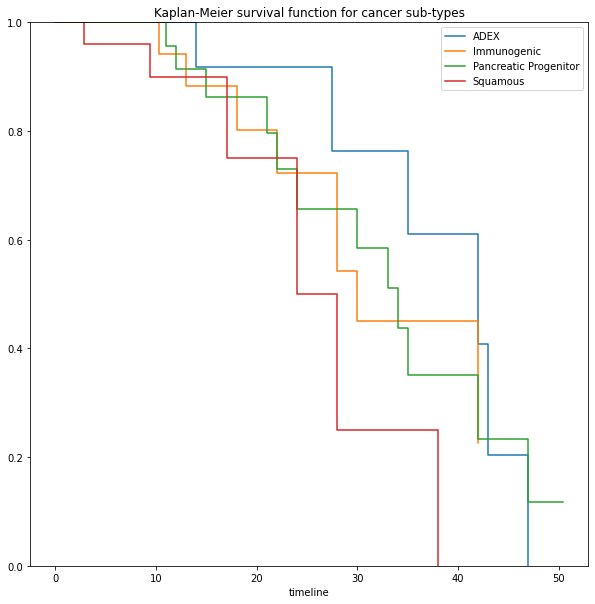

In [33]:
# кривые выживаемости в зависимости от времени для каждого подтипа (доверительные интервалы не показаны)

plt.figure(figsize=(10, 10))
ax = plt.subplot(111)

kmf.fit(T[S=='ADEX'], event_observed=E[S=='ADEX'], label="ADEX")
kmf.plot(ax=ax, ci_show=False)

kmf.fit(T[S=='Immunogenic'], event_observed=E[S=='Immunogenic'], label="Immunogenic")
kmf.plot(ax=ax, ci_show=False)

kmf.fit(T[S=='Pancreatic Progenitor'], event_observed=E[S=='Pancreatic Progenitor'], label="Pancreatic Progenitor")
kmf.plot(ax=ax, ci_show=False)

kmf.fit(T[S=='Squamous'], event_observed=E[S=='Squamous'], label="Squamous")
kmf.plot(ax=ax, ci_show=False)

plt.ylim(0, 1);
plt.title("Kaplan-Meier survival function for cancer sub-types");

По графикам заметно, что наиболее резко выживаемость снижается у сквамозного подтипа (что наблюдалось и при сравнении подтипов). Кривая подтип ADEX уходит вниз при достаточно больших значениях времени, что говорит о меньшей летальности этого подтипа. Графики согласуются с данными из статьи.